In [419]:
import torch as t
import matplotlib.pyplot as plt

In [20]:
def timeit(callable, N=200):
    from time import time
    start = time()
    for n in range(N):
        callable()
    print(f"{N} iterations of callable in: {time() - start}s")

In [313]:
phi_ext = t.tensor(3.132167875629024).cdouble()
EJ = 62.83185307179586
EC = 0.6283185307179586

T = 10
q_max = 8
NHilbert = q_max*2 + 1

Id = t.eye(NHilbert).cdouble()
q = t.arange(-q_max,q_max+1,1)
q_mat = t.diag(q).cdouble()

cos_mat = 0.5*(t.diag(t.ones(NHilbert-1),-1) + t.diag(t.ones(NHilbert-1),1)).cdouble()
# cos2_mat = 0.5*(t.diag(t.ones(NHilbert-2).cdouble(),-2)*t.exp(-1j*phi_ext) \
#                             + t.diag(t.ones(NHilbert-2),2)*t.exp(1j*phi_ext))

KinE = 4*EC*(t.kron(q_mat**2,Id) + t.kron(Id,q_mat**2))
V_mat = EJ*t.kron(q_mat,Id)
cos_mat = t.kron(cos_mat,Id) + t.kron(Id,cos_mat)

upper = t.diag(t.ones(NHilbert-1).cfloat(),1)
lower = t.diag(t.ones(NHilbert-1).cfloat(),-1)
cos2_mat = 0.5*(t.exp(1j*phi_ext)*t.kron(lower,upper) + t.exp(-1j*phi_ext)*t.kron(upper,lower))

In [314]:
alpha = 0.8
H = KinE - EJ*(cos_mat + alpha*cos2_mat)

In [623]:
lr = 1e-2
envelope_amp = 0.02397 + lr*0.70203979
detuning = 0.2956 + lr*(-6.16579341)
omega_d = 4.5
phase =	1.7529 + lr*(-3.89125348)

decline_end = 10.0+0.1
ascend_start = 20.0-0.1

In [327]:
@t.jit.script
def custom_Sigmoid(x: t.Tensor) -> t.Tensor:
    return t.sigmoid(20*t.pi/4*(x-1))

@t.jit.script
def envelope_func(times: t.Tensor,
                  envelope_amp: float = envelope_amp,
                  decline_end: float = decline_end,
                  ascend_start: float = ascend_start) -> t.Tensor:
    return envelope_amp*custom_Sigmoid(times-decline_end)*custom_Sigmoid(ascend_start - times)

@t.jit.script
def get_control(times: t.Tensor, 
                detuning: float = detuning, 
                omega_d: float = omega_d, 
                phase: float = phase, 
                envelope_amp: float = envelope_amp, 
                decline_end: float = decline_end, 
                ascend_start: float = ascend_start) -> t.Tensor:
    
    pulse = t.cos(detuning*omega_d*(times - decline_end - phase))
    envelope = envelope_func(times)
    return envelope*pulse

@t.jit.script
def get_H(times: t.Tensor,
          H: t.Tensor = H,
          V_mat: t.Tensor = V_mat) -> t.Tensor:
    V = get_control(times)*V_mat
    return H + V

In [343]:
@t.jit.script
def func(times: float,
         y: t.Tensor) -> t.Tensor:
    times = t.as_tensor(times).view(-1)
    y = y.view(-1,1)
    H = get_H(times)
    return H@y*(-1j)

@t.jit.script
def jac(times: float,
        y: t.Tensor) -> t.Tensor:
     times = t.as_tensor(times).view(-1)
     H = get_H(times)
     return H*(-1j)

In [338]:
import numpy as np
H = np.asarray(H)
V_mat = np.asarray(V_mat)

In [624]:
from numba import jit

@jit
def custom_Sigmoid(x: float) -> float:
    arg = 20*np.pi/4*(x-1)
    return 1/(1 + np.exp(-arg))

@jit
def envelope_func(times: float,
                  envelope_amp: float = envelope_amp,
                  decline_end: float = decline_end,
                  ascend_start: float = ascend_start) -> float:
    return envelope_amp*custom_Sigmoid(times-decline_end)*custom_Sigmoid(ascend_start - times)

@jit
def get_control(times: float, 
                detuning: float = detuning, 
                omega_d: float = omega_d, 
                phase: float = phase, 
                envelope_amp: float = envelope_amp, 
                decline_end: float = decline_end, 
                ascend_start: float = ascend_start) -> float:
    
    pulse = np.cos(detuning*omega_d*(times - decline_end - phase))
    envelope = envelope_func(times)
    return envelope*pulse

@jit
def get_H(times: float,
          H: np.ndarray = H,
          V_mat: np.ndarray = V_mat) -> np.ndarray:
    V = get_control(times)*V_mat
    return H + V

In [640]:
eigvals, eigvecs = np.linalg.eigh(H)
y0 = eigvecs[:,0]

# y0 = np.zeros(NHilbert**2,dtype=np.complex128)
# y0[0] = 1

# V2_mat = eigvecs.T.conj()@V_mat@eigvecs

@jit
def _H(times: float) -> np.ndarray: #,       V_mat: np.ndarray = V2_mat
    H = get_H(times)
    # G = np.diag(np.exp(1j*eigvals*times))
    # H = G@V_mat@G.conj()*get_control(times)
    return H

@jit
def func(times: float,
         y: np.ndarray) -> np.ndarray:
    # y = np.ascontiguousarray(y)
    H = _H(times)
    out = np.dot(H,y)*(-1j)
    return out

@jit
def jac(times: float,
        y: np.ndarray) -> np.ndarray:
     H = _H(times)
     return H*(-1j)

In [627]:
out2 = solve_ivp(func,
                y0=y0,
                rtol=1e-10,
                atol=1e-12,
                t_span=[10,20],
                t_eval=t.linspace(10,20,100),
                vectorized=False,
                method='BDF',
                jac=jac)

In [643]:
out = solve_ivp(func,
                y0=y0,
                rtol=1e-12,
                atol=1e-15,
                t_span=[10,20],
                t_eval=t.linspace(10,20,100),
                vectorized=False,
                method='BDF',
                jac=jac)

In [508]:
from scipy.integrate import solve_ivp

out1 = solve_ivp(func,
                y0=y0,
                rtol=1e-10,
                atol=1e-12,
                t_span=[10,20],
                t_eval=t.linspace(10,20,100),
                vectorized=False,
                method='BDF',
                jac=jac)

In [514]:
out1

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 17028
     njev: 1
      nlu: 1421
      sol: None
   status: 0
  success: True
        t: array([10.      , 10.10101 , 10.202021, 10.30303 , 10.40404 , 10.505051,
       10.606061, 10.70707 , 10.808081, 10.909091, 11.010101, 11.111111,
       11.212121, 11.313131, 11.414142, 11.515151, 11.616161, 11.717172,
       11.818182, 11.919191, 12.020202, 12.121212, 12.222222, 12.323232,
       12.424242, 12.525252, 12.626263, 12.727272, 12.828282, 12.929293,
       13.030303, 13.131312, 13.232323, 13.333333, 13.434343, 13.535353,
       13.636363, 13.737373, 13.838384, 13.939393, 14.040403, 14.141414,
       14.242424, 14.343433, 14.444444, 14.545454, 14.646464, 14.747474,
       14.848485, 14.949495, 15.050506, 15.151515, 15.252525, 15.353536,
       15.454546, 15.555555, 15.656566, 15.757576, 15.858586, 15.959596,
       16.060606, 16.161615, 16.262627, 16.363636, 16.464647, 16.565657,
       16.666

In [522]:
out

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 54784
     njev: 1
      nlu: 4570
      sol: None
   status: 0
  success: True
        t: array([10.      , 10.10101 , 10.202021, 10.30303 , 10.40404 , 10.505051,
       10.606061, 10.70707 , 10.808081, 10.909091, 11.010101, 11.111111,
       11.212121, 11.313131, 11.414142, 11.515151, 11.616161, 11.717172,
       11.818182, 11.919191, 12.020202, 12.121212, 12.222222, 12.323232,
       12.424242, 12.525252, 12.626263, 12.727272, 12.828282, 12.929293,
       13.030303, 13.131312, 13.232323, 13.333333, 13.434343, 13.535353,
       13.636363, 13.737373, 13.838384, 13.939393, 14.040403, 14.141414,
       14.242424, 14.343433, 14.444444, 14.545454, 14.646464, 14.747474,
       14.848485, 14.949495, 15.050506, 15.151515, 15.252525, 15.353536,
       15.454546, 15.555555, 15.656566, 15.757576, 15.858586, 15.959596,
       16.060606, 16.161615, 16.262627, 16.363636, 16.464647, 16.565657,
       16.666

In [628]:
np.square(np.abs(eigvecs.T.conj()@out2.y))[:3,-1], np.square(np.abs(eigvecs.T.conj()@out.y))[:3,-1], np.square(np.abs(out1.y))[:3,-1]

(array([0.23560378, 0.76208588, 0.00079782]),
 array([0.60098907, 0.39475346, 0.00216285]),
 array([0.60099142, 0.39475493, 0.00216286]))

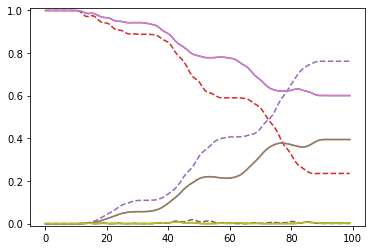

In [630]:
# plt.imshow(np.square(np.abs(out1.y)))
plt.plot(np.square(np.abs(eigvecs.T.conj()@out.y))[:3].T)
plt.plot(np.square(np.abs(eigvecs.T.conj()@out2.y))[:3].T,linestyle='--')
plt.ylim(-0.01,1.01)
# plt.yscale('log')
plt.plot(np.square(np.abs(out1.y))[:3].T)
# 

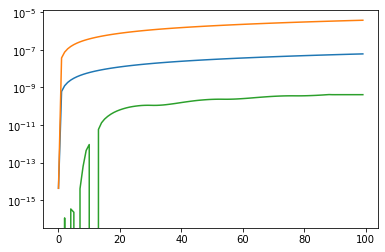

In [646]:
plt.plot((1- np.square(np.abs(eigvecs.T.conj()@out.y)).cumsum(0))[-1])
plt.plot((1- np.square(np.abs(eigvecs.T.conj()@out2.y)).cumsum(0))[-1])
plt.plot((1 - np.square(np.abs(out1.y)).cumsum(0))[-1])
plt.yscale('log')

In [498]:
K = H.real
S = H.imag
rV_mat = V_mat.real

upper = np.concatenate([S,-K],axis=1)
lower = np.concatenate([K, S],axis=1)
rH = np.concatenate([upper,lower],axis=0)

eigvals, eigvecs = np.linalg.eigh(H)
y0 = eigvecs[:,0]
u = y0.real
v = -y0.imag
y0 = np.concatenate([u,v],axis=0)

In [499]:
@jit
def _rH(times: float,
       rV_mat: np.ndarray = rV_mat,
       rH: np.ndarray = rH) -> np.ndarray:
    rV = rV_mat*get_control(times)
    rH = rH.copy()
    rH[:289,289:] -= rV
    rH[289:,:289] += rV
    return rH

@jit
def func(times: float,
         y: np.ndarray) -> np.ndarray:
    # y = np.ascontiguousarray(y)
    H = _rH(times)
    out = np.dot(H,y)
    return out

@jit
def jac(times: float,
        y: np.ndarray) -> np.ndarray:
     H = _rH(times)
     return H

In [500]:
func(15,y0).shape

(578,)

In [503]:
rout = solve_ivp(func,
                 y0=y0,
                 rtol=1e-8,
                 atol=1e-10,
                 t_span=[10,20],
                 t_eval=t.linspace(10,20,100),
                 vectorized=False,
                 method='LSODA',
                 jac=jac)

TypeError: not enough arguments: expected 2, got 1

In [552]:
y0_aug[:289].shape,y0_aug[-3:].shape,y0_aug.shape

((289,), (3,), (292,))

In [582]:
a = - (out.y[:,[-1]].T.conj()@eigvecs[:,[0]]@eigvecs[:,[0]].T.conj()).squeeze()
a_theta = np.zeros(3)
psi  = out.y[:,-1]
y0_aug = np.concatenate([a,psi,a_theta],axis=0)
# y0_aug = [a,a_theta]
# from typing import List



@jit
def dudtheta(times: float,
            theta: np.ndarray, 
            omega_d: float = omega_d, 
            decline_end: float = decline_end, 
            ascend_start: float = ascend_start) -> np.ndarray:

    E = custom_Sigmoid(times-decline_end)*custom_Sigmoid(ascend_start - times)
    T = times - decline_end - theta[2]
    pulse = np.cos(theta[1]*omega_d*T)
    sin_pulse = np.sin(detuning*omega_d*T)
    return np.array([E*pulse,
                     -theta[0]*E*omega_d*T*sin_pulse,
                     theta[0]*E*theta[1]*omega_d*sin_pulse])

@jit
def augmented_dynamics(times: float,
                       y0_aug: np.ndarray) -> np.ndarray:
    # a = y0_aug[:-3]
    # a_theta = y0_aug[-3:]
    N = 289
    out = np.zeros_like(y0_aug)
    H = get_H(times)
    out[:289] = -np.dot(y0_aug[:289],H)*(-1j)
    out[289:-3] = np.dot(H,y0_aug[289:-3])*(-1j)
    out[-3:] = np.dot(y0_aug[:289],np.kron(np.dot(V_mat,y0_aug[289:-3]).reshape(-1,1),dudtheta(times,y0_aug[-3:])))*(-1j)
    return out


In [596]:
aout = solve_ivp(augmented_dynamics,
                 t_span=(20,10),
                 rtol=1e-10,
                 atol=1e-12,
                 y0=y0_aug,
                 t_eval=[10],
                 method = 'BDF')

In [597]:
aout

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 108999
     njev: 5
      nlu: 8703
      sol: None
   status: 0
  success: True
        t: array([10])
 t_events: None
        y: array([[-1.57633794e-09-3.18820678e-10j],
       [-1.36413386e-08-4.47785673e-09j],
       [-8.43014341e-08-3.68033991e-08j],
       [-3.47846222e-07-2.01150717e-07j],
       [-7.40673130e-07-6.64257401e-07j],
       [ 4.84081556e-07-8.25181987e-07j],
       [ 6.78326612e-06+2.30626247e-06j],
       [ 1.11969169e-05+9.06371985e-06j],
       [-8.60945787e-06+4.01043085e-06j],
       [-3.02963427e-05-1.74452479e-05j],
       [ 2.15003655e-06-1.15610401e-05j],
       [ 2.58168729e-05+1.38814976e-05j],
       [-3.53380119e-07+6.14888979e-06j],
       [-7.65945447e-06-4.14909426e-06j],
       [-2.77543432e-07-1.25520801e-06j],
       [ 8.72137413e-07+4.06899441e-07j],
       [ 1.09680749e-07+1.34005305e-07j],
       [-6.33650042e-09+2.95232015e-10j],
       [-7.51367128e

In [600]:
np.square(np.abs(eigvecs.T.conj()@aout.y[289:-3]))[0]

array([0.99999379])

In [622]:
aout.y[-3:], aout.y[-3:].real

(array([[ 0.70203979+0.95581894j],
        [-6.16579341-0.05347543j],
        [-3.89125348-0.06887704j]]),
 array([[ 0.70203979],
        [-6.16579341],
        [-3.89125348]]))

In [584]:
aout = solve_ivp(augmented_dynamics,
                 t_span=(20,10),
                 y0=y0_aug,
                 t_eval=[10],
                 method = 'BDF')

# out = solve_ivp(func,
#                 y0=y0,
#                 rtol=1e-10,
#                 atol=1e-12,
#                 t_span=[10,20],
#                 t_eval=t.linspace(10,20,100),
#                 vectorized=False,
#                 method='BDF',
#                 jac=jac)

C:\Users\jv97\AppData\Local\Temp/ipykernel_60704/2498058850.py:33: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 1d, A), array(complex128, 2d, C))
  out[:289] = -np.dot(y0_aug[:289],H)*(-1j)
C:\Users\jv97\AppData\Local\Temp/ipykernel_60704/2498058850.py:35: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (readonly array(complex128, 2d, C), array(complex128, 1d, A))
  out[-3:] = np.dot(y0_aug[:289],np.kron(np.dot(V_mat,y0_aug[289:-3]).reshape(-1,1),dudtheta(times,y0_aug[-3:])))*(-1j)


In [585]:
aout

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 21113
     njev: 417
      nlu: 2591
      sol: None
   status: 0
  success: True
        t: array([10])
 t_events: None
        y: array([[-3.44895856e-04+4.41623641e-04j],
       [ 3.42323655e-04-4.45025564e-04j],
       [-1.85599401e-04+2.45734946e-04j],
       [ 7.22536500e-05-9.87090627e-05j],
       [-2.37069353e-05+3.16312739e-05j],
       [ 6.75079581e-06-1.00986374e-05j],
       [ 5.03609349e-06+4.94449075e-06j],
       [ 1.08981814e-05+8.45602768e-06j],
       [-8.52483361e-06+3.85079347e-06j],
       [-2.88850279e-05-1.78826072e-05j],
       [ 2.36094397e-06-1.14877376e-05j],
       [ 2.52297535e-05+1.62676332e-05j],
       [-4.20348751e-06-3.50563488e-06j],
       [ 1.05280462e-05+3.30623155e-05j],
       [-6.60627368e-05-1.21250749e-04j],
       [ 1.73916113e-04+2.87409933e-04j],
       [-2.57934143e-04-3.99919690e-04j],
       [ 3.44387232e-04-4.42678110e-04j],
       [-2.88895937

In [593]:
np.square(np.abs(eigvecs.T.conj()@aout.y[289:-3])).cumsum()

array([0.94509899, 0.94510217, 0.94510336, 0.94510476, 0.94510493,
       0.94510495, 0.94510495, 0.94510495, 0.94510495, 0.94510495,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510496,
       0.94510496, 0.94510496, 0.94510496, 0.94510496, 0.94510

In [595]:
aout.y[-3:]

array([[-101.36718159-1.47459093e+02j],
       [  12.98358757+5.43974144e-02j],
       [  -8.99245328-8.02559582e-03j]])

In [614]:
funcky(1,ty0)

1 [tensor([0.5418, 0.6520, 0.8035, 0.9901, 0.2396, 0.4149, 0.6664, 0.7055, 0.9120,
        0.1662]), tensor([0.8774, 0.3233, 0.4114, 0.0189, 0.0549]), tensor([0.5749])]


[tensor([0.8774, 0.3233, 0.4114, 0.0189, 0.0549]),
 tensor([-0.5418, -0.6520, -0.8035, -0.9901, -0.2396, -0.4149, -0.6664, -0.7055,
         -0.9120, -0.1662]),
 tensor([0.5749])]

In [621]:
ty0 = t.as_tensor([t.rand(10),t.rand(5),t.rand(1)])
ty0
# def funcky(times, y):
#     print(times, y)
#     return t.tensor([times*y[1],-times*y[0],y[2]])

# tout = solve_ivp(funcky,
#                 y0=ty0,
#                 t_span=[0,1],
#                 method='BDF')

ValueError: only one element tensors can be converted to Python scalars